## Notebook 1: AG's News Topic Classification using Natural Language Processing

**1. Prepare prolem**

In [1]:
# a) Load libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import string
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization, Dropout
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# b) Load the data
train_df = pd.read_csv('train.csv', delimiter=',', header=None, names=['index', 'title', 'description'])
test_df = pd.read_csv('test.csv', delimiter=',', header=None, names=['index', 'title', 'description'])

**2. Exploratory Data Analysis**

In [3]:
train_df.head()

,index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [4]:
test_df.head()

,index,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


The train and test sets each consist of three columns, representing the index (four classes), title, and descriptions.

In [5]:
# Basic statistics
train_df.describe(include='all')

,index,title,description
count,120000.000000,120000,120000
unique,NaN,114364,118731
top,NaN,Today's schedule,"With the economy slowly turning up, upgrading ..."
freq,NaN,39,15
mean,2.500000,NaN,NaN
std,1.118039,NaN,NaN
min,1.000000,NaN,NaN
25%,1.750000,NaN,NaN
50%,2.500000,NaN,NaN
75%,3.250000,NaN,NaN


In [6]:
# Count missing values
print(train_df.isna().sum())

# Drop records with missing values
train_df.dropna(inplace=True)

# Fill missing values with a default value
train_df.fillna('Unknown', inplace=True)

index          0
title          0
description    0
dtype: int64


<Axes: xlabel='index', ylabel='count'>

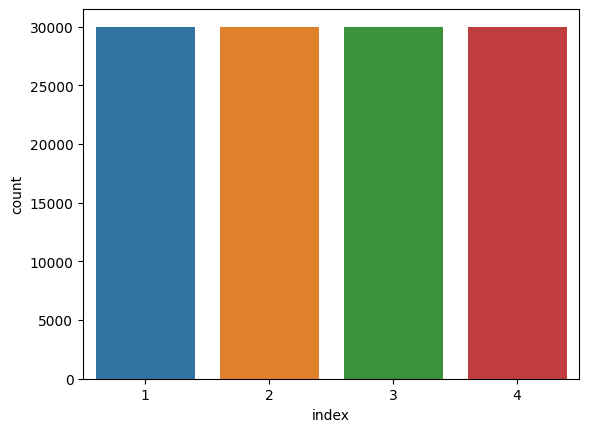

In [7]:
# Class distribution
sns.countplot(x='index', data=train_df)

As evidenced by the plot, the dataset is well-balanced with an equal distribution of classes.

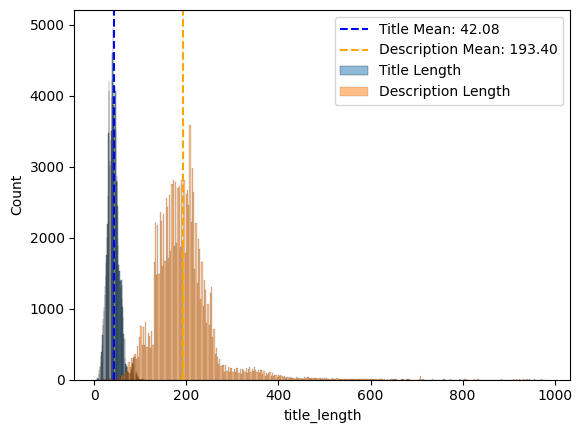

In [8]:
# Text length analysis
train_df['title_length'] = train_df['title'].apply(len)
train_df['description_length'] = train_df['description'].apply(len)

title_mean = np.mean(train_df['title_length'])
desc_mean = np.mean(train_df['description_length'])

sns.histplot(train_df['title_length'], label='Title Length', alpha=0.5)
sns.histplot(train_df['description_length'], label='Description Length', alpha=0.5)

plt.axvline(title_mean, color='blue', linestyle='--', label=f"Title Mean: {title_mean:.2f}")
plt.axvline(desc_mean, color='orange', linestyle='--', label=f"Description Mean: {desc_mean:.2f}")

plt.legend()
plt.show()

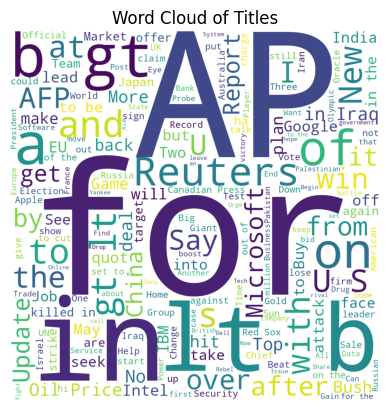

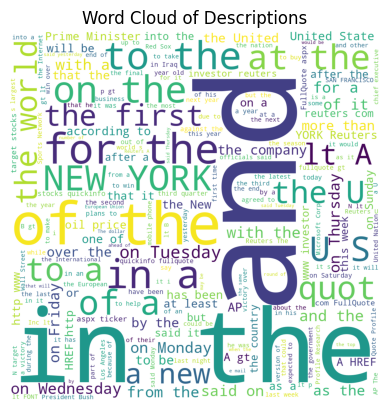

In [9]:
# Word frequency analysis
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=1200, height=1200, background_color='white', stopwords=set()).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

all_titles = ' '.join(train_df['title'].values)
all_descriptions = ' '.join(train_df['description'].values)

plot_wordcloud(all_titles, "Word Cloud of Titles")
plot_wordcloud(all_descriptions, "Word Cloud of Descriptions")

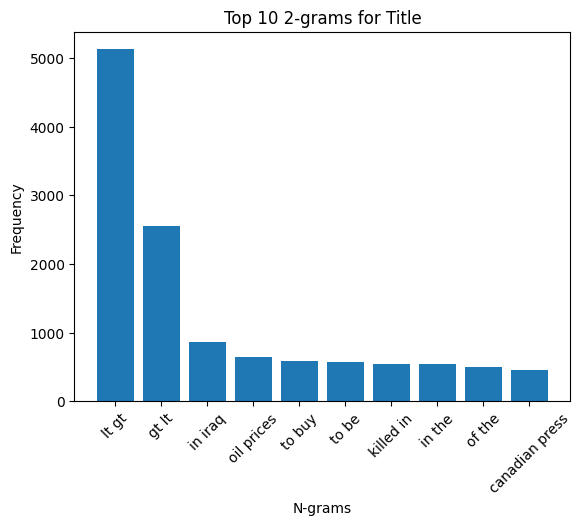

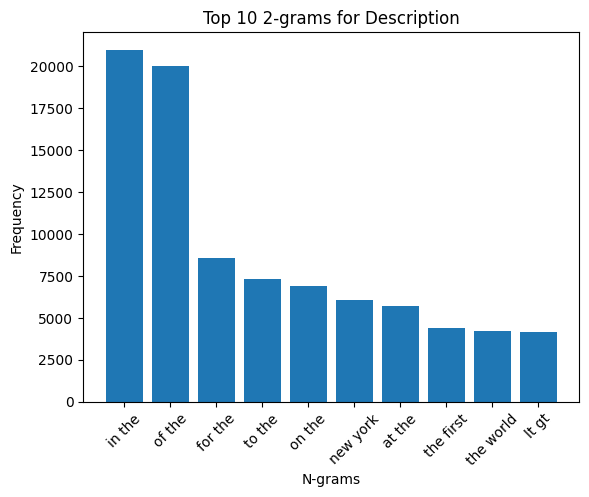

In [10]:
# N-gram analysis
def plot_top_ngrams(corpus, n, g, text_type):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    
    plt.bar([x[0] for x in words_freq], [x[1] for x in words_freq])
    plt.xticks(rotation=45)
    plt.xlabel("N-grams")
    plt.ylabel("Frequency")
    plt.title(f"Top {n} {g}-grams for {text_type}")
    plt.show()

plot_top_ngrams(train_df['title'], 10, 2, "Title")
plot_top_ngrams(train_df['description'], 10, 2, "Description")

The N-gram analysis reveals the most frequently occurring n-grams (sequences of words) within the 'title' and 'description' columns, which aids in identifying common phrases and patterns present in the text data.

**3. Prepare Data**

In [11]:
# a) Data cleaning
def clean_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

In [12]:
# Apply clean_doc to each document in the DataFrame
train_df['cleaned_title'] = train_df['title'].apply(clean_doc)
train_df['cleaned_description'] = train_df['description'].apply(clean_doc)

test_df['cleaned_title'] = test_df['title'].apply(clean_doc)
test_df['cleaned_description'] = test_df['description'].apply(clean_doc)

In [13]:
# b) Preprocessing function
def preprocess(text):
    if not isinstance(text, str):
        return ''
    
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    return text

In [14]:
# Apply preprocessing
train_df['cleaned_description'] = train_df['description'].apply(preprocess)
test_df['cleaned_description'] = test_df['description'].apply(preprocess)

In [15]:
# c) Split the training data into train and validation sets
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

**4. Evaluate Algorithms**

In [16]:
# Define the vocabulary list
vocabulary = ['World', 'Sports', 'Business', 'Sci/Tech']
vocabulary = [word.lower() for word in vocabulary]

Training a Word2Vec model on the training data before applying model training and evaluation is beneficial because it allows to capture semantic information from the text in the form of word embeddings. Word2Vec is a popular method for generating dense vector representations of words, and these embeddings are useful in various NLP tasks, including text classification.

In [17]:
# Train a Word2Vec model on the training data
sentences = [row.split() for row in train_df['cleaned_description']]
sentences.extend([[word] for word in vocabulary])
word2vec = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4)

In [18]:
def get_avg_vec(text, model, vector_size):
    words = text.split()
    vec_sum = np.zeros(vector_size)
    count = 0
    for word in words:
        if word in model.wv:
            vec_sum += model.wv[word]
            count += 1
    if count != 0:
        vec_sum /= count
    return vec_sum

In [19]:
# Define train, validation and test sets
X_train_word2vec = np.array([get_avg_vec(text, word2vec, 300) for text in train_data['cleaned_description']])
X_val_word2vec = np.array([get_avg_vec(text, word2vec, 300) for text in val_data['cleaned_description']])
X_test_word2vec = np.array([get_avg_vec(text, word2vec, 300) for text in test_df['cleaned_description']])

y_train = train_data['index']
y_val = val_data['index']
y_test = test_df['index']

In [20]:
# a) Train and evaluate SVM on Word2Vec features
svm_word2vec = SVC()
svm_word2vec.fit(X_train_word2vec, y_train)
y_pred_svm = svm_word2vec.predict(X_val_word2vec)
print("SVM Word2Vec Accuracy:", accuracy_score(y_val, y_pred_svm))

SVM Word2Vec Accuracy: 0.8831666666666667


In [21]:
# Interpretation confusion matrix SVC
y_pred_svm = svm_word2vec.predict(X_test_word2vec)
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:\n", cm_svm)

Confusion Matrix:
 [[1655   68   97   80]
 [  36 1824   15   25]
 [  84   24 1568  224]
 [  65   47  158 1630]]


In [22]:
# Classification Report
report_svm = classification_report(y_test, y_pred_svm)
print("Classification Report:\n", report_svm)

Classification Report:
               precision    recall  f1-score   support

           1       0.90      0.87      0.89      1900
           2       0.93      0.96      0.94      1900
           3       0.85      0.83      0.84      1900
           4       0.83      0.86      0.84      1900

    accuracy                           0.88      7600
   macro avg       0.88      0.88      0.88      7600
weighted avg       0.88      0.88      0.88      7600



In [23]:
# b) Train and evaluate Random Forest on Word2Vec features
rf_word2vec = RandomForestClassifier()
rf_word2vec.fit(X_train_word2vec, y_train)
y_pred_rf = rf_word2vec.predict(X_val_word2vec)
print("Random Forest Word2Vec Accuracy:", accuracy_score(y_val, y_pred_rf))

Random Forest Word2Vec Accuracy: 0.8604583333333333


In [24]:
# Interpretation Random Forest
y_pred_rf = rf_word2vec.predict(X_test_word2vec)
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm_rf)

Confusion Matrix:
 [[1651   82  105   62]
 [  38 1811   17   34]
 [ 101   45 1510  244]
 [  88   60  195 1557]]


In [25]:
# Classification Report
report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:\n", report_rf)

Classification Report:
               precision    recall  f1-score   support

           1       0.88      0.87      0.87      1900
           2       0.91      0.95      0.93      1900
           3       0.83      0.79      0.81      1900
           4       0.82      0.82      0.82      1900

    accuracy                           0.86      7600
   macro avg       0.86      0.86      0.86      7600
weighted avg       0.86      0.86      0.86      7600



In [26]:
# c) Train and evaluate using LSTM:
# Tokenize and pad sequences
max_len = 100
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data['cleaned_description'])
sequences_train = tokenizer.texts_to_sequences(train_data['cleaned_description'])
sequences_val = tokenizer.texts_to_sequences(val_data['cleaned_description'])
sequences_test = tokenizer.texts_to_sequences(test_df['cleaned_description'])

X_train_seq = pad_sequences(sequences_train, maxlen=max_len)
X_val_seq = pad_sequences(sequences_val, maxlen=max_len)
X_test_seq = pad_sequences(sequences_test, maxlen=max_len)

y_train_cat = to_categorical(y_train - 1)
y_val_cat = to_categorical(y_val - 1)
y_test_cat = to_categorical(y_test - 1)

In [27]:
# Build the LSTM model
vocab_size = len(tokenizer.word_index) + 1

model = Sequential()
model.add(Embedding(vocab_size, 300, input_length=max_len))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          16785300  
                                                                 
 batch_normalization (BatchN  (None, 100, 300)         1200      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 128)               219648    
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [28]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive 
# epochs (patience=10)
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

Epoch 1/50
750/750 [==============================] - 67s 78ms/step - loss: 0.4177 - accuracy: 0.8569 - val_loss: 0.2707 - val_accuracy: 0.9107
Epoch 2/50
750/750 [==============================] - 22s 29ms/step - loss: 0.1825 - accuracy: 0.9386 - val_loss: 0.2905 - val_accuracy: 0.9084
Epoch 3/50
750/750 [==============================] - 16s 22ms/step - loss: 0.1117 - accuracy: 0.9604 - val_loss: 0.3353 - val_accuracy: 0.9039
Epoch 4/50
750/750 [==============================] - 17s 23ms/step - loss: 0.0775 - accuracy: 0.9726 - val_loss: 0.3757 - val_accuracy: 0.8984
Epoch 5/50
750/750 [==============================] - 15s 20ms/step - loss: 0.0579 - accuracy: 0.9798 - val_loss: 0.4300 - val_accuracy: 0.8982
Epoch 6/50
750/750 [==============================] - 16s 21ms/step - loss: 0.0454 - accuracy: 0.9842 - val_loss: 0.4694 - val_accuracy: 0.8976
Epoch 7/50
750/750 [==============================] - 16s 21ms/step - loss: 0.0407 - accuracy: 0.9855 - val_loss: 0.4990 - val_accuracy:

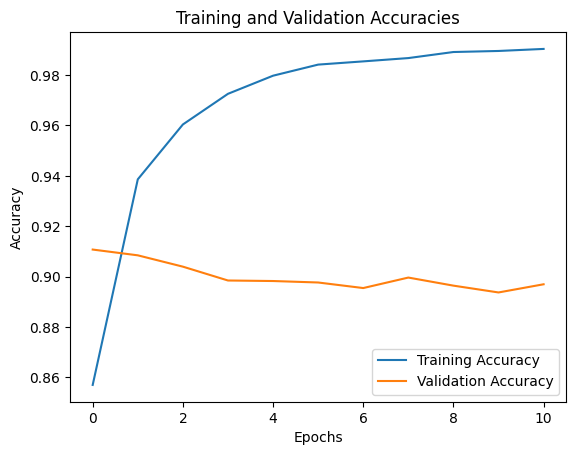

In [29]:
# Train and evaluate the LSTM model
history = model.fit(X_train_seq, y_train_cat, validation_data=(X_val_seq, y_val_cat), epochs=50, batch_size=128, callbacks=[early_stopping])

# Plot the training and validation accuracies
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracies')
plt.show()

238/238 [==============================] - 1s 6ms/step - loss: 0.5631 - accuracy: 0.8983
LSTM Accuracy: 0.8982895016670227


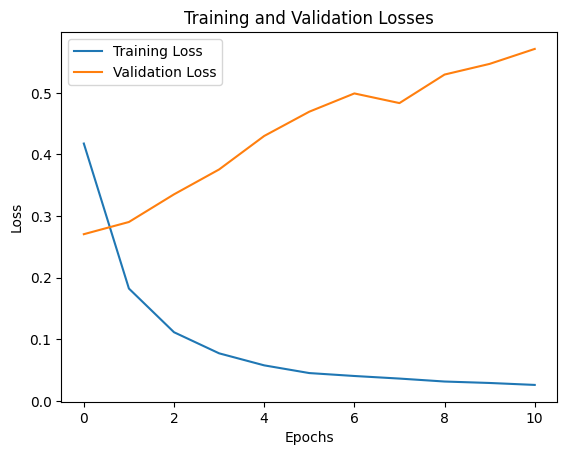

In [30]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat)
print("LSTM Accuracy:", test_acc)

# Plot the training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

Although the LSTM model's training and validation performances exhibit some degree of overfitting, BatchNormalization and Dropout layers have been incorporated to mitigate this issue. Further adjustments may be necessary to optimize the model.

In [31]:
y_pred_prob = model.predict(X_test_seq)

238/238 [==============================] - 1s 4ms/step


In [32]:
y_pred_LSTM = np.argmax(y_pred_prob, axis = 1)+1

In [33]:
# Classification Report
report_LSTM = classification_report(y_test, y_pred_LSTM)
print("Classification Report:\n", report_LSTM)

Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.89      0.90      1900
           2       0.95      0.97      0.96      1900
           3       0.85      0.87      0.86      1900
           4       0.87      0.87      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



Text(95.72222222222221, 0.5, 'Truth')

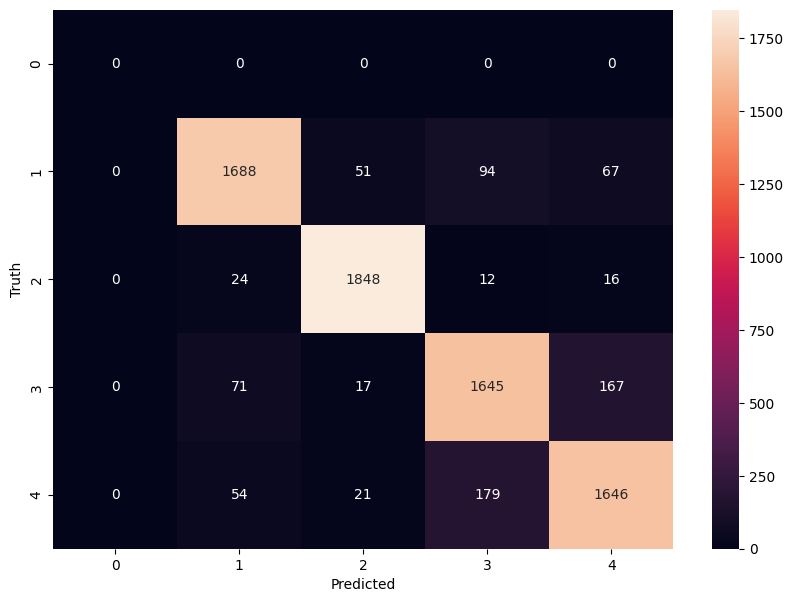

In [34]:
# Interpretation confusion matrix LSTM
cm_LSTM = tf.math.confusion_matrix(labels = y_test, predictions = y_pred_LSTM)
plt.figure(figsize = (10, 7))
sns.heatmap(cm_LSTM, annot = True, fmt = 'd')
plt.xlabel ('Predicted')
plt.ylabel('Truth')

**5. Conclusions**

- The exploratory data analysis revealed that the dataset is well-balanced. The mean values for title and description lengths are 42 and 193, respectively.

- Among the three machine learning algorithms tested, the Long Short-Term Memory (LSTM) model demonstrated superior performance, achieving an accuracy of approximately 90%. This surpassed the results of both Support Vector Machines (SVM) and Random Forest (RF) models.

- The LSTM model, consisting of five layers (embedding, LSTM, dense, batchNormalization, and dropout), delivered a reasonable performance, albeit with some degree of overfitting. Further fine-tuning of hyperparameters could potentially yield even better prediction scores.